In [1]:
# packages: random
import random

# packages: data structure
import numpy as np
import pandas as pd
import astropy.io as io

# packages: astro image generation
from astropy.modeling.models import Sersic2D, Gaussian2D, Moffat2D

# image manipulation
from scipy.signal import convolve2d

# packages: image generation and plot generation
from matplotlib import pyplot as plt
import seaborn

### Do's

* Primary
    * add flag for the class of object
* Secondary
    * how to draw from distributions
    * download real sky data
    * mixing different things in one table
* Done
    * efficiently create arrays for the tabular data
    * function for load data
    * visualization of examples


In [2]:
# pandas
# https://pandas.pydata.org/pandas-docs/stable/tutorials.html
# https://pandas.pydata.org/pandas-docs/stable/10min.html

# ndimage: image manipulation
# https://docs.scipy.org/doc/scipy/reference/ndimage.html#module-scipy.ndimage

# ascii:io
# http://docs.astropy.org/en/stable/io/ascii/

# matplotlib
# https://nickcharlton.net/posts/drawing-animating-shapes-matplotlib.html

# astropy: modeling:
# http://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Sersic2D.html

# data
# https://arxiv.org/pdf/1608.04369.pdf

## Define Objects and Images

In [104]:
def _patch2im(thepatch, imshape):
    """
    Convert patch to image
    """
    
    # Create meshgrid of coordinates
    y = np.arange(1, imshape[0])
    x = np.arange(1, imshape[1])
    g = np.meshgrid(x, y)

    # Define coords
    coords = np.array(list(zip(*(c.flat for c in g))))

    # Create path
    elpath = Path(thepatch.get_verts())

    # Determine all points in the grid ithat are in the path.
    validcoords = elpath.contains_points(coords)
    ellipsepoints = coords[validcoords]

    # Set output
    outim = np.zeros(imshape)
    outim[ellipsepoints[:, 0], ellipsepoints[:, 1]] = 1

    return outim


def empty_imshape(n_pix_side, nb_channels=1):
    """
    Create empty canvas.
    """
    
    return np.zeros((n_pix_side, n_pix_side))#, nb_channels))#, np.uint8)


def create_line(imshape, x_start, y_start, x_end, y_end, width):
    """
    Create a line.
    """
    
    # Create the arc patch we want to add to the image
    return None


def create_arc(imshape, center, radius, width, theta1, theta2):
    """
    Create an arc (outline of a circle) with a specified
    thickness (width).
    """

    # Create the arc patch we want to add to the image
    arc = Wedge(center, radius, theta1, theta2, width)

    return _patch2im(arc, imshape)


def create_circle(imshape, center, radius, width):
    """
    Create a circle.
    """

    # Create the arc patch we want to add to the image
    return create_arc(imshape, center, radius, width=width, theta1=0, theta2=360)
  

def create_polygon(imshape, xy, width, height, angle=0.0, fill=True):
    """
    Create a polygon
    """

    # Create the arc patch we want to add to the image
    rect = Rectangle(xy, width, height, angle=0.0, fill=fill)

    return _patch2im(rect, imshape)


def create_meshgrid(imshape):
    """
    Create MeshGrid
    """
    
    return np.meshgrid(np.arange(np.shape(imshape)[0]), np.arange(np.shape(imshape)[1]))


def create_Sersic2D(imshape, 
                    amplitude=1,
                    x_0=50, 
                    y_0=50,
                    radius=25, 
                    n=4, 
                    ellip=.5, 
                    theta=-1 
                    ):
    """
    Create Galaxy profile: Sersic
    """
    
    x, y = create_meshgrid(imshape)
    mod = Sersic2D(amplitude=amplitude,
                   x_0=x_0, 
                   y_0=y_0,
                   r_eff=radius, 
                   n=n,
                   ellip=ellip, 
                   theta=theta
                  )
    
    return mod(x, y)


def create_Moffat2D(imshape,
                    amplitude=1,
                    x_0=0, 
                    y_0=0, 
                    radius=1, 
                    alpha=1
                   ):
    """
    Create Star profile: Moffat
    """
    
    x, y = create_meshgrid(imshape)
    mod = Moffat2D(amplitude=amplitude, 
                   x_0=x_0, 
                   y_0=y_0, 
                   gamma=radius, 
                   alpha=alpha)
    
    return mod(x, y) 


def create_Gaussian(imshape, 
                    amplitude=1, 
                    x_mean=0, y_mean=0, 
                    x_stddev=None, y_stddev=None, 
                    theta=None):
    """
    Create Gaussian
    """
    
    x, y = create_meshgrid(imshape)
    
    mod = Gaussian2D(amplitude=1, 
                      x_mean=x_mean, y_mean=y_mean,
                      x_stddev=x_stddev, y_stddev=y_stddev, 
                      theta=theta)
    
    return mod(x, y) 


def create_psf(imshape):
    """
    Add PSF to image
    """
    
    impsf = np.ones((np.shape(imshape)[0],np.shape(imshape)[1])) #/ 25   

    return convolve2d(imshape, impsf, 'same')
                    

def create_noise(imshape, noise_level):
    """
    Create noise image
    https://kmdouglass.github.io/posts/modeling-noise-for-image-simulations.html
    """
    
    seed = 42
    rs = np.random.RandomState(seed)
    
    return rs.poisson(noise_level, (np.shape(imshape)[0],np.shape(imshape)[1]))
    
    
def combine_sky_imshape(imshape_list, amplitude_list):
    """
    Combine clean sky images
    """
    
    imshape_new = np.zeros((imshape_list[0].shape[0], imshape_list[0].shape[1]))
    for imshape, amplitude in zip(imshape_list, amplitude_list):
        imshape_new += amplitude*imshape
        
    return imshape_new    

## Generate Catalogs

In [105]:
def generate_catalog(n_obj, 
                     n_pix_side, 
                     myclass,
                     id_start=0, 
                     amplitude=1,
                     amplitude_min=1,
                     amplitude_max=1.,
                     radius_min=2,
                     radius_max=20,
                     verbose=False):
    """
    Generate data set: catalog
    """

    # fac = -1.0
    # np.random.uniform(0 - fac* radius_max, n_pix_side + fac* radius_max, n_obj)
    
    # Define column names
    column_names = ['id', 'x_center', 'y_center', 'radius', 'amplitude', 'myclass']

    # Data Frame: Tabular Data for Objects
    catalog = pd.DataFrame(np.empty((n_obj, len(column_names))),columns=column_names)

    catalog.id = np.arange(n_obj) + id_start
    catalog.x_center = n_pix_side / 2.
    catalog.y_center = n_pix_side / 2.
    catalog.radius = np.random.uniform(radius_min, radius_max, n_obj)
    catalog.amplitude = np.random.uniform(amplitude_min, amplitude_max, n_obj)
    catalog.myclass = myclass
    
    return catalog

                      
def generate_imageset(catalog, n_pix_side, noise, verbose=False):
    """
    Generate data set: images
    """

    # count objects
    n_obj = len(catalog)
    
    # create image list
    images = np.empty((n_obj, n_pix_side, n_pix_side))
    
    for ind, _ in enumerate(images):
        images[ind] = generate_image(catalog.loc[ind], n_pix_side, noise)

    return images


def generate_image(catalog_single, n_pix_side, noise):
    """
    Generate a single image
    """

    imshape = empty_imshape(n_pix_side)
    
    if catalog_single.myclass == 1:

        imshape = create_Sersic2D(imshape, 
                                    x_0=catalog_single.x_center, 
                                    y_0=catalog_single.y_center,
                                    radius=catalog_single.radius 
                                )
    elif catalog_single.myclass == 0:
        imshape =  create_Moffat2D(imshape,
                                    x_0=catalog_single.x_center, 
                                    y_0=catalog_single.y_center,
                                    radius=catalog_single.radius
                                   )

    # apply amplitude
    imshape *= catalog_single.amplitude
    
    # add noise
    noise = create_noise(imshape, noise)
    imshape += noise
    

    return imshape

## Prepare Data

In [44]:
def combine_data(frames, data_type):  
    """
    Combine classes of data
    """
    
    if data_type=='catalog':
        data = pd.concat(frames)
    elif data_type=='image':
        data = np.concatenate(frames)
    else:
        data = None
        
    return data


def randomize_data(catalog, imageset, seed=5, verbose=False):
    """
    Randomize the data
    """
 
    # create randomized indices
    random.seed(seed)  
    n_catalog = len(catalog)
    ind_random = np.arange(n_catalog)
    random.shuffle(ind_random)
    
    # re-order data based on randomized indices
    catalog = catalog.iloc[ind_random]
    imageset = imageset[ind_random]

    return catalog, imageset, ind_random


def recast_imageset(imageset):
    """
    Recast imageset as numpy uint8
    """
    imageset = imageset.astype(np.uint8)
    
    return imageset


def recast_imageset_bits(imageset):
    """
    Recast imageset as numpy uint8
    """
    imageset = np.unpackbits(imageset)
    
    return imageset

## I/O

In [45]:
def save_data(f_data_list, data_list, data_type, verbose=False):
    """
    Save Data to File
    """
    
    if data_type == 'catalog':
        # Pandas Data Frame for tabular data: save to file
        data_list.to_csv(f_data_list)
    elif data_type == 'image':
        # Numpy Array for image data: save to file
        np.save(f_data_list, data_list)
     
    return     


def load_data(f_data_list, data_type, verbose=False):
    """
    Load Data from File
    """
    
    if data_type == 'catalog':
        data_list = pd.read_csv(f_data_list)
    elif data_type == 'image':
        data_list = np.load(f_data_list)
        
    return data_list
    

# Visualize

In [102]:
def show_example(imshape, imshape_2=None, log=False):
    f = plt.figure(figsize=(18, 4))

    f.add_subplot(1,2, 1)
    if log:
        imshape = np.log10(imshape)
    plt.imshow(imshape, origin='lower', interpolation='nearest',
               vmin=-1, vmax=2)
    plt.xlabel('x')
    plt.ylabel('y')
    cbar = plt.colorbar()
    cbar.set_label('Brightness', rotation=270, labelpad=25)
    cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)

    if imshape_2 is not None:
        f.add_subplot(1,2, 2)
        if log:
            imshape_2 = np.log10(imshape_2)
        plt.imshow(imshape_2, origin='lower', interpolation='nearest',
                   vmin=-1, vmax=2)
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('Brightness', rotation=270, labelpad=25)
        cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)

    plt.show(block=True)
    
    
def show_encoded(): 
    """
    Show the encoded layer representation
    """
    num_images = 10
    np.random.seed(42)
    random_test_images = np.random.randint(x_test.shape[0], size=num_images)

    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = autoencoder.predict(x_test)



    plt.figure(figsize=(18, 4))

    print(encoded_imgs[0].shape)
    num_rows=4
    num_pixel_x = 2
    num_pixel_y = 4

    for i, image_idx in enumerate(random_test_images):
        # plot original image
        ax = plt.subplot(4, num_images, i + 1)
        plt.imshow(x_test[image_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # plot encoded image
        ax = plt.subplot(num_rows, num_images, num_images + i + 1)

        plt.imshow(encoded_imgs[image_idx].reshape(num_pixel_x, num_pixel_y), interpolation=None, resample=None)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # plot encoded image
        ax = plt.subplot(num_rows, num_images, 2*num_images + i + 1)
        print(np.min(encoded_imgs[image_idx].reshape(num_pixel_x, num_pixel_y)), np.max(encoded_imgs[image_idx].reshape(num_pixel_x, num_pixel_y)))

        plt.imshow(encoded_imgs[image_idx].reshape(num_pixel_x, num_pixel_y).astype('uint8'), interpolation=None, resample=None)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        # plot reconstructed image
        ax = plt.subplot(num_rows, num_images, 3*num_images + i + 1)
        plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    
def plot_distributions(data, xlabel):
    f = plt.figure(figsize=(12, 4))

    plt.hist(data)
    plt.xlabel(xlabel)

    

# Test

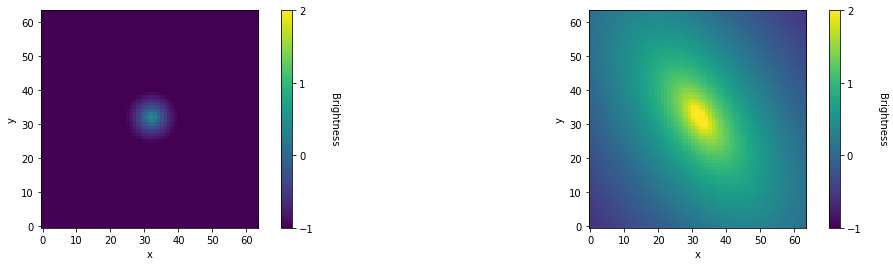

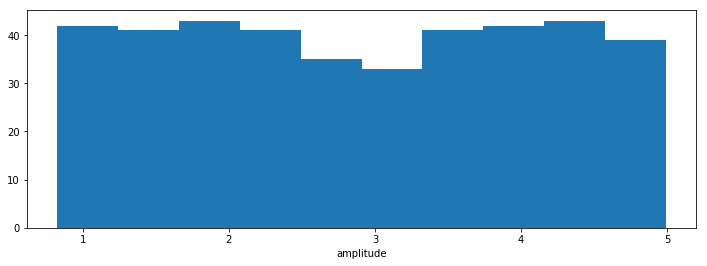

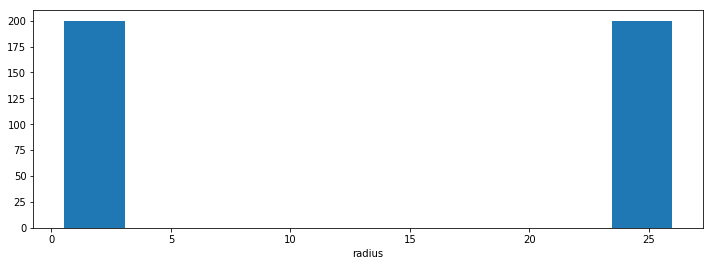

In [132]:
# Meta data
n_obj = 200
n_pix_side = 64
noise = 0.

# generate catalogs
catalog_gal = generate_catalog(n_obj, 
                                 n_pix_side, 
                                 1,
                                 id_start=0, 
                                 amplitude_min=0.8,
                                 amplitude_max=5.0,                               
                                 radius_min=24,
                                 radius_max=26,
                                 verbose=False)

catalog_star = generate_catalog(n_obj, 
                                 n_pix_side, 
                                 0,
                                 id_start=len(catalog_gal), 
                                 amplitude_min=0.8,
                                 amplitude_max=5.0,                                
                                 radius_min=0.5,
                                 radius_max=2,
                                 verbose=False)

# generate images
imageset_gal = generate_imageset(catalog_gal, n_pix_side, noise, verbose=False)
imageset_star = generate_imageset(catalog_star, n_pix_side, noise, verbose=False)

# combine catalogs
catalog_combined = combine_data([catalog_gal, catalog_star], 'catalog')
imageset_combined = combine_data([imageset_gal, imageset_star], 'image')

catalog_combined, imageset_combined, _ = randomize_data(catalog_combined, imageset_combined, seed=5, verbose=False)

# imageset_combined = recast_imageset(imageset_combined)
#print(imageset_combined)

# save 

# visualize
show_example(imageset_combined[0], imshape_2=imageset_combined[1], log=True)

plot_distributions(catalog_combined.amplitude, 'amplitude')
plot_distributions(catalog_combined.radius, 'radius')
# save 

In [168]:
# import packages for Convolutional AutoEncoder compression
import keras
from keras import regularizers, optimizers
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Reshape
from keras import backend as K


from IPython.display import Image, SVG
import matplotlib.pyplot as plt

In [175]:
# Prep
nb_train = 1000
nb_test = 1000
nb_epochs = 6



In [176]:
x_train_temp = imageset_combined[0:nb_train,:,:]
x_test_temp = imageset_combined[nb_train:nb_train + nb_test,:,:]

y_train_temp = catalog_combined[0:nb_train]
y_test_temp = catalog_combined[0:nb_train]
#print(y_train_temp)

In [177]:
(x_train_temp, _), (x_test_temp, _) = mnist.load_data()
x_train_temp = x_train_temp[0:nb_train,:,:]
x_test_temp = x_test_temp[0:nb_test,:,:]

x_train_temp.shape, x_test_temp.shape

((1000, 28, 28), (1000, 28, 28))

In [178]:
max_value = float(x_train_temp.max())
x_train = x_train_temp.astype('float32') / max_value
x_test = x_test_temp.astype('float32') / max_value

x_train.shape, x_test.shape


((1000, 28, 28), (1000, 28, 28))

In [179]:
n_pix_side = x_train.shape[2]
x_train = x_train.reshape((len(x_train), n_pix_side, n_pix_side, 1))
x_test = x_test.reshape((len(x_test), n_pix_side, n_pix_side, 1))

(x_train.shape, x_test.shape)
print(x_train.shape)

(1000, 28, 28, 1)


In [185]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#keras.backend.set_floatx('float32')

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(16, (3, 3), strides=(2,2), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(4, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten(name='flatten_1'))
autoencoder.add(Reshape((1, 1, 4),name='latent'))

# Decoder Layers
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu'))#,padding='same'))
#autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()
sgd = optimizers.SGD(lr=0.0000005, decay=1e-6, momentum=0.9, nesterov=True)

autoencoder.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])


print()
print('======================================================================')
print('======================================================================')
print('======================================================================')
print()

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten_1').output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_270 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_271 (Conv2D)          (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_272 (Conv2D)          (None, 4, 4, 16)          4624      
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_273 (Conv2D)          (None, 1, 1, 8)           1160      
__________

In [186]:
history = autoencoder.fit(x_train, x_train,
                          epochs=nb_epochs,
                          batch_size=32,
                          validation_data=(x_test, x_test), verbose=True)

Train on 1000 samples, validate on 1000 samples
Epoch 1/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2313 - acc: 0.6501 - val_loss: 0.2317 - val_acc: 0.6932
Epoch 2/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2313 - acc: 0.7174 - val_loss: 0.2317 - val_acc: 0.7420
Epoch 3/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2313 - acc: 0.7530 - val_loss: 0.2317 - val_acc: 0.7687
Epoch 4/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2313 - acc: 0.7733 - val_loss: 0.2317 - val_acc: 0.7853
Epoch 5/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2313 - acc: 0.7861 - val_loss: 0.2317 - val_acc: 0.7962
Epoch 6/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2313 - acc: 0.7944 - val_loss: 0.2316 - val_acc: 0.8033


In [182]:
encoded_imgs = encoder.predict(x_test)

encoded_imgs_16 = encoded_imgs.astype('float16')

for img, img16 in zip(encoded_imgs, encoded_imgs_16):
    print(encoded_imgs[0])    
#    print(encoded_imgs_16[0])


[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]
[-0.          0.01459738 -0.          0.00299369]


(1000, 28, 28)


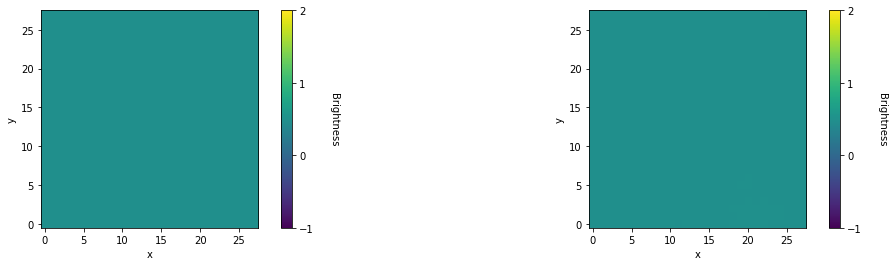

In [187]:
decoded_imgs = autoencoder.predict(x_test)
decoded_imgs = decoded_imgs.reshape((decoded_imgs.shape[0], n_pix_side, n_pix_side))
print(decoded_imgs.shape)
show_example(decoded_imgs[0], imshape_2=decoded_imgs[1])
#print(decoded_imgs[0])

# OLD

In [ ]:
from keras import backend as K
K.floatx()
K.set_floatx('float16')
K.floatx()


https://colab.research.google.com/drive/1E0URjxq_vlvrDVeLTsUIsgQOkoS9Gf94#scrollTo=yoKEbjT05rb8
    https://colab.research.google.com/drive/1TfflYirHKJkVuX2jGwyjOLKplthzQP74